# Rank and Rank Distribution Plots

This notebook compares ranks and rank distributions using original activations and activations with the optimal arithmetic-derived direction (intervention). If precomputed probabilities are missing, it can recompute them from saved activations using the unembedding weights and final layer norm.


In [38]:
# Config
import os
import pickle
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer


@dataclass
class Config:
    model_name: str = "meta-llama/Llama-3.1-8B"
    base: int = 8
    final_layer: int = 31
    alpha: float = 0.05


cfg = Config()

# Resolve base paths consistent with existing utils
model_dir = cfg.model_name.split("/")[-1]
base_dir = f"/home/ljilesen/interaction-experiment/notebooks/notebooks/utils/{model_dir}/base{cfg.base}"
orig_input_dir = base_dir

# Only for base8
if cfg.base == 8:
    interv_input_dir = (
        f"/home/ljilesen/interaction-experiment/outputs/arithmetic/intervention/optimal_base8_eval"
    )
else:
    interv_input_dir = None
print("Original dir:", orig_input_dir)
print("Intervention dir:", interv_input_dir)


Original dir: /home/ljilesen/interaction-experiment/notebooks/notebooks/utils/Llama-3.1-8B/base8
Intervention dir: /home/ljilesen/interaction-experiment/outputs/arithmetic/intervention/optimal_base8_eval


In [ ]:
# Loaders for expressions, probs, activations
os.environ["HF_TOKEN"]=""

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

def load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)


def path_exists(path: str) -> bool:
    try:
        return os.path.exists(path)
    except Exception:
        return False


# Expected files (aligned with utils/logit_lens.ipynb)
expr_path_orig = f"{orig_input_dir}/expressions_base{cfg.base}.pkl"
probs_path_orig = f"{orig_input_dir}/logit_lens_results_base{cfg.base}.pkl"
acts_path_orig = f"{orig_input_dir}/layer_activations_base{cfg.base}.pkl"

expr_path_int = f"{interv_input_dir}/expressions_base{cfg.base}.pkl"
probs_path_int = f"{interv_input_dir}/logit_lens_results_base{cfg.base}.pkl"
acts_path_int = f"{interv_input_dir}/layer_activations_base{cfg.base}.pkl"

print("Checking file availability...")
for p in [expr_path_orig, probs_path_orig, acts_path_orig, expr_path_int, probs_path_int, acts_path_int]:
    print(f" - {p}: {'OK' if path_exists(p) else 'MISSING'}")

expressions = load_pickle(expr_path_orig)
expressions_int = load_pickle(expr_path_int) if path_exists(expr_path_int) else expressions

# Load probs if available
loaded_probs_orig: Optional[List[torch.Tensor]] = load_pickle(probs_path_orig) if path_exists(probs_path_orig) else None
loaded_probs_int: Optional[List[torch.Tensor]] = load_pickle(probs_path_int) if path_exists(probs_path_int) else None

# Load activations (used for recompute fallback)
loaded_acts_orig = load_pickle(acts_path_orig) if path_exists(acts_path_orig) else None
loaded_acts_int = load_pickle(acts_path_int) if path_exists(acts_path_int) else None

print(
    f"Probs orig: {loaded_probs_orig is not None}, Probs int: {loaded_probs_int is not None}; "
    f"Acts orig: {loaded_acts_orig is not None}, Acts int: {loaded_acts_int is not None}"
)


Checking file availability...
 - /home/ljilesen/interaction-experiment/notebooks/notebooks/utils/Llama-3.1-8B/base8/expressions_base8.pkl: OK
 - /home/ljilesen/interaction-experiment/notebooks/notebooks/utils/Llama-3.1-8B/base8/logit_lens_results_base8.pkl: OK
 - /home/ljilesen/interaction-experiment/notebooks/notebooks/utils/Llama-3.1-8B/base8/layer_activations_base8.pkl: OK
 - /home/ljilesen/interaction-experiment/outputs/arithmetic/intervention/optimal_base8_eval/expressions_base8.pkl: OK
 - /home/ljilesen/interaction-experiment/outputs/arithmetic/intervention/optimal_base8_eval/logit_lens_results_base8.pkl: OK
 - /home/ljilesen/interaction-experiment/outputs/arithmetic/intervention/optimal_base8_eval/layer_activations_base8.pkl: OK
Probs orig: True, Probs int: True; Acts orig: True, Acts int: True


In [43]:
# Utilities: build labels and digit index mapping, compute ranks

# Reuse logic from utils/logit_lens.ipynb

def get_label(expr: str, base: int) -> str:
    lhs, rhs = expr.split("+")
    lhs_base10 = int(lhs, base)
    rhs_base10 = int(rhs, base)
    sum_base10 = lhs_base10 + rhs_base10
    return np.base_repr(sum_base10, base)


def prepare_dataset_labels(expressions: List[str], base: int, tokenizer: AutoTokenizer):
    expr_labels = []
    for i in range(len(expressions)):
        label = get_label(expressions[i], base)
        token_ids = tokenizer.encode(label, add_special_tokens=False)
        try:
            rw_label = get_label(expressions[i], 10)
            rw_token_ids = tokenizer.encode(rw_label, add_special_tokens=False)
        except Exception:
            rw_label = None
            rw_token_ids = []
        item = {
            "expr": expressions[i],
            "label": label,
            "token_ids": token_ids,
            "token_str": tokenizer.decode(token_ids),
            "rw_label": rw_label,
            "rw_token_ids": rw_token_ids,
            "rw_token_str": tokenizer.decode(rw_token_ids) if len(rw_token_ids) > 0 else "",
        }
        expr_labels.append(item)
    return expr_labels


expr_labels = prepare_dataset_labels(expressions, cfg.base, tokenizer)
# Build digit token indices (0..999) mapping consistent with utils
digit_token_indices = torch.tensor([tokenizer.encode(str(i), add_special_tokens=False)[0] for i in range(1000)])
digit_token_to_position = {tid.item(): i for i, tid in enumerate(digit_token_indices)}

# Tensors of target indices into the digit subset
rw_token_ids = torch.tensor([label["rw_token_ids"][0] for label in expr_labels])
token_ids = torch.tensor([label["token_ids"][0] for label in expr_labels])
correct_token_id_indices = torch.tensor([digit_token_to_position[tid.item()] for tid in token_ids])
real_world_token_id_indices = torch.tensor([digit_token_to_position[tid.item()] for tid in rw_token_ids])


def probs_to_digit_ranks(layer_probs: torch.Tensor, digit_token_indices: torch.Tensor) -> torch.Tensor:
    # layer_probs: (num_instances, vocab_size)
    digit_token_distributions = layer_probs[:, digit_token_indices]
    _, ranks = torch.sort(digit_token_distributions, descending=True)
    digit_token_ranks = torch.argsort(ranks, dim=1) + 1
    return digit_token_ranks


def extract_target_ranks(digit_token_ranks: torch.Tensor,
                         correct_indices: torch.Tensor,
                         real_world_indices: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    correct_ranks = digit_token_ranks.gather(1, correct_indices.unsqueeze(1)).squeeze(1)
    real_world_ranks = digit_token_ranks.gather(1, real_world_indices.unsqueeze(1)).squeeze(1)
    return correct_ranks, real_world_ranks


In [44]:
# Compute ranks across layers for original and intervention

def normalize_layer_probs(layer_probs_raw) -> List[torch.Tensor]:
    # Accept dict keyed by layer, list/tuple, numpy arrays; coerce to List[Tensor]
    if isinstance(layer_probs_raw, dict):
        items = [layer_probs_raw[k] for k in sorted(layer_probs_raw.keys())]
    else:
        items = list(layer_probs_raw)
    normalized: List[torch.Tensor] = []
    for item in items:
        arr = item
        if isinstance(arr, dict):
            if 'probs' in arr:
                arr = arr['probs']
            else:
                raise TypeError("Expected layer item to be Tensor/ndarray or dict with 'probs'")
        if isinstance(arr, np.ndarray):
            arr = torch.from_numpy(arr)
        elif not isinstance(arr, torch.Tensor):
            arr = torch.tensor(arr)
        normalized.append(arr)
    return normalized


def compute_ranks_across_layers(layer_probs_list) -> Dict[int, Dict[str, torch.Tensor]]:
    layer_to_ranks: Dict[int, Dict[str, torch.Tensor]] = {}
    if layer_probs_list is None:
        return layer_to_ranks
    probs_by_layer = normalize_layer_probs(layer_probs_list)

    # Sample one random digit position per instance, excluding both correct and real-world positions
    num_instances = correct_token_id_indices.shape[0]
    num_digits = 1000
    rng = np.random.default_rng(42)
    rand_positions_list = []
    for i in range(num_instances):
        cpos = int(correct_token_id_indices[i].item())
        rpos = int(real_world_token_id_indices[i].item())
        if cpos == rpos:
            # If same (edge-case), exclude just one
            allowed = np.setdiff1d(np.arange(num_digits), np.array([cpos]), assume_unique=False)
        else:
            allowed = np.setdiff1d(np.arange(num_digits), np.array([cpos, rpos]), assume_unique=False)
        rand_positions_list.append(int(rng.choice(allowed)))
    rand_digit_positions = torch.tensor(rand_positions_list, dtype=torch.long)

    for layer_idx, layer_probs in enumerate(probs_by_layer):
        digit_ranks = probs_to_digit_ranks(layer_probs, digit_token_indices)
        corr_ranks, rw_ranks = extract_target_ranks(
            digit_ranks, correct_token_id_indices, real_world_token_id_indices
        )
        rand_ranks = digit_ranks.gather(1, rand_digit_positions.unsqueeze(1)).squeeze(1)
        layer_to_ranks[layer_idx] = {
            "correct": corr_ranks.cpu(),
            "real_world": rw_ranks.cpu(),
            "random": rand_ranks.cpu(),
        }
    return layer_to_ranks


ranks_orig = compute_ranks_across_layers(loaded_probs_orig) if loaded_probs_orig is not None else None
ranks_int = compute_ranks_across_layers(loaded_probs_int) if loaded_probs_int is not None else None

print("Ranks ready:", ranks_orig is not None, ranks_int is not None)


Ranks ready: True True


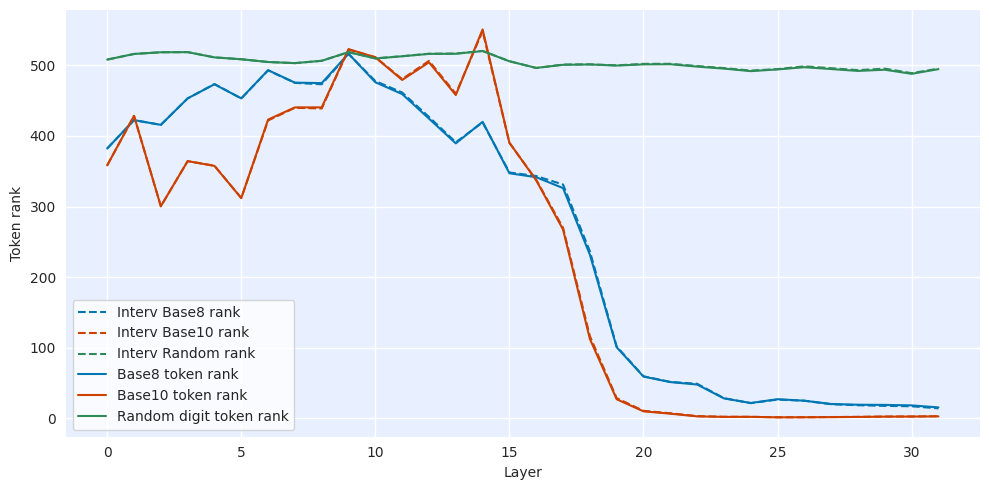

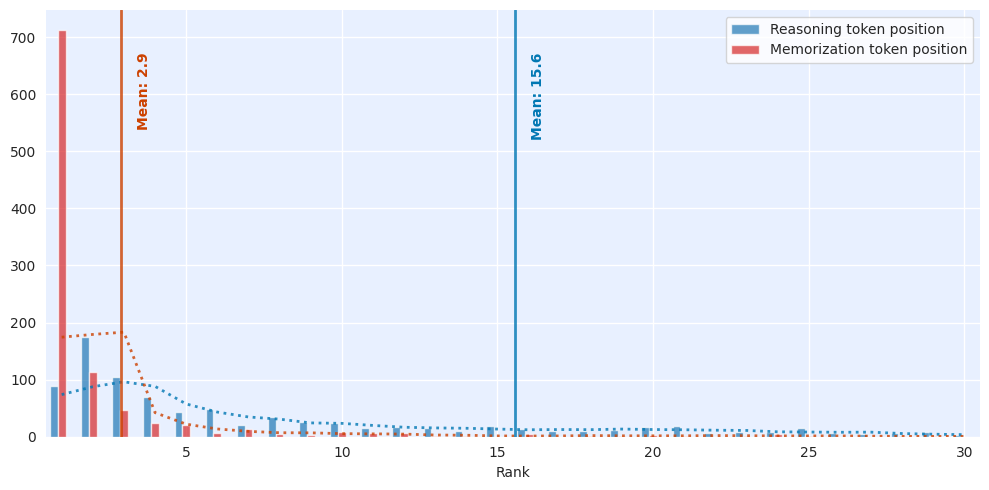

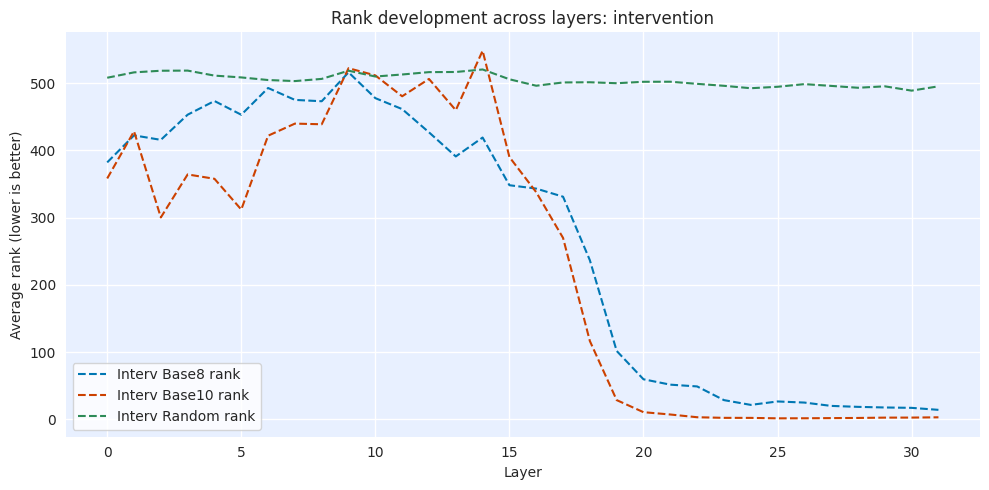

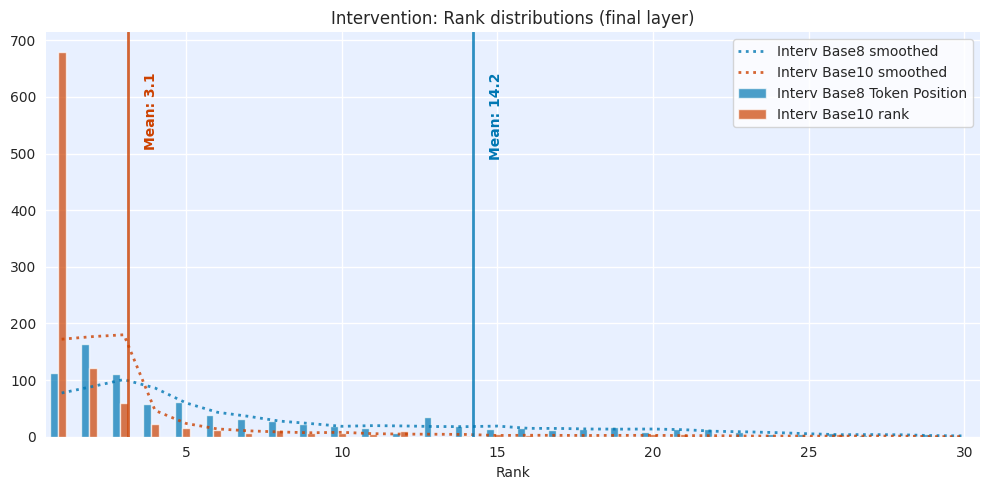

In [45]:
# Plots: average rank across layers, and hist (counts) at final layer

sns.set_style("whitegrid")
light_blue = '#e8f0ff'

# Use top-30 consistently
top_k = 30
bins = list(range(1, top_k + 2))  # integer bin edges 1..top_k
x = np.arange(1, top_k + 1)

def hist_counts(arr, k=top_k):
    # Count only ranks within 1..k to align with x
    a = arr.astype(int)
    a = a[(a >= 1) & (a <= k)]
    return np.bincount(a - 1, minlength=k)

def smooth(y, frac=0.15, min_k=3, max_k=21):
    n = len(y)
    k = int(round(frac * n))
    k = max(min_k, min(max_k, k))
    if k % 2 == 0:
        k += 1
    # Ensure kernel does not exceed length and remains odd
    k = min(k, n if n % 2 == 1 else max(1, n - 1))
    if k < 3:
        return y
    w = np.ones(k) / k
    return np.convolve(y, w, mode='same')

if ranks_orig is not None:
    layers = sorted(ranks_orig.keys())
    avg_corr_orig = [ranks_orig[i]["correct"].float().mean().item() for i in layers]
    avg_rw_orig = [ranks_orig[i]["real_world"].float().mean().item() for i in layers]
    avg_rand_orig = [ranks_orig[i]["random"].float().mean().item() for i in layers]

    # Average rank development (original)
    fig, ax = plt.subplots(figsize=(10, 5))

    if ranks_int is not None:
        avg_corr_int = [ranks_int[i]["correct"].float().mean().item() for i in layers]
        avg_rw_int = [ranks_int[i]["real_world"].float().mean().item() for i in layers] 
        avg_rand_int = [ranks_int[i]["random"].float().mean().item() for i in layers]

        ax.plot(layers, avg_corr_int, label=f"Interv Base{cfg.base} rank", color="#0077B3", linestyle="--")
        ax.plot(layers, avg_rw_int, label="Interv Base10 rank", color="#CC4100", linestyle="--")
        ax.plot(layers, avg_rand_int, label="Interv Random rank", color="#2E8B57", linestyle="--")
    
    ax.plot(layers, avg_corr_orig, label=f"Base{cfg.base} token rank", color="#0077B3")
    ax.plot(layers, avg_rw_orig, label="Base10 token rank", color="#CC4100")
    ax.plot(layers, avg_rand_orig, label="Random digit token rank", color="#2E8B57")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Token rank")
    #ax.set_title("Rank development across layers: original")
    fig.patch.set_facecolor('white')
    ax.set_facecolor(light_blue)
    ax.grid(True, color='white', linewidth=1.0)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Final layer distributions (original)
    final = cfg.final_layer
    corr_orig = ranks_orig[final]["correct"].numpy()
    rw_orig = ranks_orig[final]["real_world"].numpy()
    rand_orig = ranks_orig[final]["random"].numpy()

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    
    # Create side-by-side bars
    width = 0.25
    x_pos = np.arange(1, top_k + 1)
    
    corr_counts = hist_counts(corr_orig)
    rw_counts = hist_counts(rw_orig)
    rand_counts = hist_counts(rand_orig)
    
    ax.bar(x_pos - width, corr_counts, width, color="tab:blue", label=f"Reasoning token position", alpha=0.7)
    ax.bar(x_pos, rw_counts, width, color="tab:red", label="Memorization token position", alpha=0.7)
    #ax.bar(x_pos + width, rand_counts, width, color="#2E8B57", label="Orig Random rank")
    
    ax.plot(x_pos, smooth(corr_counts), color="#0077B3", linewidth=2.0, linestyle=':', alpha=0.8)
    ax.plot(x_pos, smooth(rw_counts), color="#CC4100", linewidth=2.0, linestyle=':', alpha=0.8)
    #ax.plot(x_pos, smooth(rand_counts), color="#2E8B57", linewidth=2.0, linestyle=':', alpha=0.8, label="Orig Random smoothed")

    # Add mean rank vertical lines
    corr_mean = np.mean(corr_orig)
    rw_mean = np.mean(rw_orig)
    ax.axvline(corr_mean, color="#0077B3", linestyle='-', alpha=0.8, linewidth=2)
    ax.axvline(rw_mean, color="#CC4100", linestyle='-', alpha=0.8, linewidth=2)

    
    # Add text annotations for mean ranks
    ax.text(corr_mean + 0.5, ax.get_ylim()[1] * 0.9, f'Mean: {corr_mean:.1f}', 
            color="#0077B3", fontweight='bold', rotation=90, ha='left', va='top')
    ax.text(rw_mean + 0.5, ax.get_ylim()[1] * 0.9, f'Mean: {rw_mean:.1f}', 
            color="#CC4100", fontweight='bold', rotation=90, ha='left', va='top')
    
    #ax.set_title("Original: Rank distributions (final layer)")
    ax.set_xlabel("Rank")
    ax.set_xlim(0.5, top_k + 0.5)
    ax.set_facecolor(light_blue)
    ax.grid(True, color='white', linewidth=1.0)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.legend()
    plt.tight_layout()
    plt.show()

if ranks_int is not None:
    avg_corr_int = [ranks_int[i]["correct"].float().mean().item() for i in layers]
    avg_rw_int = [ranks_int[i]["real_world"].float().mean().item() for i in layers]
    avg_rand_int = [ranks_int[i]["random"].float().mean().item() for i in layers]

    # Average rank development (intervention)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(layers, avg_corr_int, label=f"Interv Base{cfg.base} rank", color="#0077B3", linestyle="--")
    ax.plot(layers, avg_rw_int, label="Interv Base10 rank", color="#CC4100", linestyle="--")
    ax.plot(layers, avg_rand_int, label="Interv Random rank", color="#2E8B57", linestyle="--")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Average rank (lower is better)")
    ax.set_title("Rank development across layers: intervention")
    fig.patch.set_facecolor('white')
    ax.set_facecolor(light_blue)
    ax.grid(True, color='white', linewidth=1.0)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Final layer distributions (intervention)
    final = cfg.final_layer
    corr_int = ranks_int[final]["correct"].numpy()
    rw_int = ranks_int[final]["real_world"].numpy()
    rand_int = ranks_int[final]["random"].numpy()

    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    
    # Create side-by-side bars
    width = 0.25
    x_pos = np.arange(1, top_k + 1)
    
    corr_counts = hist_counts(corr_int)
    rw_counts = hist_counts(rw_int)
    rand_counts = hist_counts(rand_int)
    
    ax.bar(x_pos - width, corr_counts, width, color="#0077B3", alpha=0.7, label=f"Interv Base{cfg.base} Token Position")
    ax.bar(x_pos, rw_counts, width, color="#CC4100", alpha=0.7, label="Interv Base10 rank")
    #ax.bar(x_pos + width, rand_counts, width, color="#2E8B57", alpha=0.7, label="Interv Random rank")
    
    ax.plot(x_pos, smooth(corr_counts), color="#0077B3", linewidth=2.0, linestyle=':', alpha=0.8, label=f"Interv Base{cfg.base} smoothed")
    ax.plot(x_pos, smooth(rw_counts), color="#CC4100", linewidth=2.0, linestyle=':', alpha=0.8, label="Interv Base10 smoothed")
    #ax.plot(x_pos, smooth(rand_counts), color="#2E8B57", linewidth=2.0, linestyle=':', alpha=0.8, label="Interv Random smoothed")
    
    # Add mean rank vertical lines
    corr_mean = np.mean(corr_int)
    rw_mean = np.mean(rw_int)
    rand_mean = np.mean(rand_int)
    ax.axvline(corr_mean, color="#0077B3", linestyle='-', alpha=0.8, linewidth=2)
    ax.axvline(rw_mean, color="#CC4100", linestyle='-', alpha=0.8, linewidth=2)
    #ax.axvline(rand_mean, color="#2E8B57", linestyle='-', alpha=0.8, linewidth=2)
    
    # Add text annotations for mean ranks
    ax.text(corr_mean + 0.5, ax.get_ylim()[1] * 0.9, f'Mean: {corr_mean:.1f}', 
            color="#0077B3", fontweight='bold', rotation=90, ha='left', va='top')
    ax.text(rw_mean + 0.5, ax.get_ylim()[1] * 0.9, f'Mean: {rw_mean:.1f}', 
            color="#CC4100", fontweight='bold', rotation=90, ha='left', va='top')
    #ax.text(rand_mean + 0.5, ax.get_ylim()[1] * 0.9, f'Mean: {rand_mean:.1f}', 
    #        color="#2E8B57", fontweight='bold', rotation=90, ha='left', va='top')
    
    ax.set_title("Intervention: Rank distributions (final layer)")
    ax.set_xlabel("Rank")
    ax.set_xlim(0.5, top_k + 0.5)
    ax.set_facecolor(light_blue)
    ax.grid(True, color='white', linewidth=1.0)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Ranks unavailable yet; will attempt recomputation if needed in the next cell.")

[445 692 558 541 536 954 229 958 155 150 155 539 835 772 624 610 269   3
 641 242 351 524 265 854 915 400 529 567 295 219 510 403  64 208 905  62
 907 932 851 753 283 881 267 593  99 592 823 493 416 677 758 374 362 521
 906 132 642  38 819 668 876 836 191 575 231 237 762 666  66 407 967 210
 864  32 484 742 410 242 673 107 250 492 153 639 370 333  98 241 808 900
 533 771 286 393 955 224 241 711 300 163 528 146 472  29 884 865 687 509
 474 496 606 830 706 576 759 784  83 102 256 105 497 595 590 575 979 811
  86 492 940 692 289 997  55 679 948 290 653 171 497 553 984 131 532 489
 762 630  87 246 887 118 856  86 820 709 225 849 256 627 670 204 910 578
 308 337 318 479 582 193 346  64  42 182 941 776 780 200 622 147 368 594
 981 208 410 925 874 490  87 785 237 270 908 402 299 464 978 121 182  80
 315 303 511 814 979 374 676 344 629 971  63 971 756 571 727 280 270 490
 116 298 359 737 120 194 515  91 662 454 860 528 575 203 408 617  60 848
 889 212 921 340 198 489 139 901 228 246 726 166 62

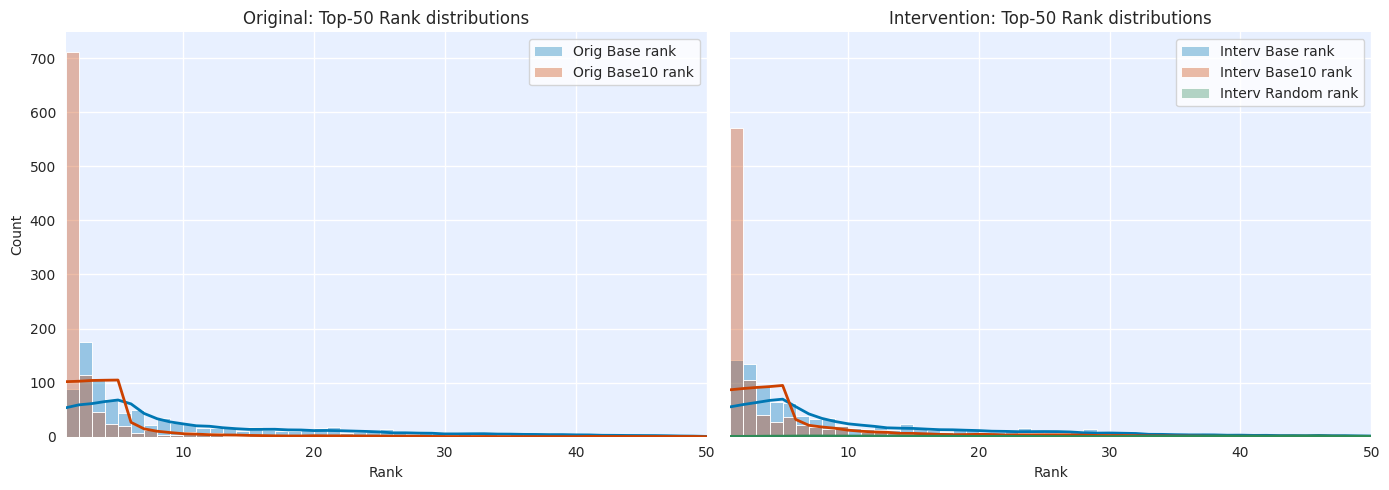

In [21]:
# Top-K (50) rank distributions with aligned smoothing

# Parameters
top_k = 50
bins = list(range(1, top_k + 2))  # edges for integer ranks 1..top_k
x = np.arange(1, top_k + 1)

def hist_counts_topk(arr, k=top_k):
    a = arr.astype(int)
    a = a[(a >= 1) & (a <= k)]
    c = np.bincount(a - 1, minlength=k)
    return c

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.patch.set_facecolor('white')

print(rand_orig)
# Original
sns.histplot(corr_orig, bins=bins, binrange=(1, top_k), color="#0077B3", alpha=0.35, stat="count", kde=False, label="Orig Base rank", ax=axes[0])
sns.histplot(rw_orig,  bins=bins, binrange=(1, top_k), color="#CC4100", alpha=0.35, stat="count", kde=False, label="Orig Base10 rank", ax=axes[0])
#sns.histplot(rand_orig, bins=bins, binrange=(1, top_k), color="#2E8B57", alpha=0.35, stat="count", kde=False, label="Orig Random rank", ax=axes[0])
axes[0].plot(x, smooth(hist_counts_topk(corr_orig)), color="#0077B3", linewidth=2.0)
axes[0].plot(x, smooth(hist_counts_topk(rw_orig)),  color="#CC4100", linewidth=2.0)
#axes[0].plot(x, smooth(hist_counts_topk(rand_orig)), color="#2E8B57", linewidth=2.0)
axes[0].set_title("Original: Top-50 Rank distributions")
axes[0].set_xlabel("Rank")
axes[0].legend()

# Intervention
sns.histplot(corr_int, bins=bins, binrange=(1, top_k), color="#0077B3", alpha=0.35, stat="count", kde=False, label="Interv Base rank", ax=axes[1])
sns.histplot(rw_int,  bins=bins, binrange=(1, top_k), color="#CC4100", alpha=0.35, stat="count", kde=False, label="Interv Base10 rank", ax=axes[1])
sns.histplot(rand_int, bins=bins, binrange=(1, top_k), color="#2E8B57", alpha=0.35, stat="count", kde=False, label="Interv Random rank", ax=axes[1])
axes[1].plot(x, smooth(hist_counts_topk(corr_int)), color="#0077B3", linewidth=2.0)
axes[1].plot(x, smooth(hist_counts_topk(rw_int)),  color="#CC4100", linewidth=2.0)
axes[1].plot(x, smooth(hist_counts_topk(rand_int)), color="#2E8B57", linewidth=2.0)
axes[1].set_title("Intervention: Top-50 Rank distributions")
axes[1].set_xlabel("Rank")
axes[1].legend()

for ax in axes:
    ax.set_xlim(1, top_k)
    ax.set_facecolor(light_blue)
    ax.grid(True, color='white', linewidth=1.0)
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()


In [7]:
# Fallback: recompute probs from activations using saved unembedding and final layer norm

unembed_path = f"/home/ljilesen/interaction-experiment/notebooks/notebooks/utils/{model_dir}/unembed_weights.pt"
fln_path = f"/home/ljilesen/interaction-experiment/notebooks/notebooks/utils/{model_dir}/final_layer_norm.pt"


def load_weights() -> Tuple[torch.Tensor, torch.nn.Module]:
    unembed = torch.load(unembed_path, weights_only=True)
    final_layer_norm = torch.load(fln_path, weights_only=False)
    return unembed, final_layer_norm


def logit_lens(unembed_weights: torch.Tensor, final_layer_norm: torch.nn.Module, activations: torch.Tensor) -> torch.Tensor:
    # activations: (num_instances, hidden_dim)
    # final_layer_norm applies elementwise normalization
    with torch.no_grad():
        normed_h = final_layer_norm(activations)
        logits = torch.matmul(normed_h, unembed_weights.T)
        probs = torch.softmax(logits, dim=-1)
    return probs


need_recompute_orig = (loaded_probs_orig is None) and (loaded_acts_orig is not None)
need_recompute_int = (loaded_probs_int is None) and (loaded_acts_int is not None)

if need_recompute_orig or need_recompute_int:
    print("Recomputing missing probabilities from activations...")
    unembed_weights, final_layer_norm = load_weights()

    if need_recompute_orig:
        recomputed_probs_orig: List[torch.Tensor] = []
        for layer_idx in range(len(loaded_acts_orig)):
            layer_acts = loaded_acts_orig[layer_idx]
            layer_probs = logit_lens(unembed_weights, final_layer_norm, layer_acts)
            recomputed_probs_orig.append(layer_probs)
        loaded_probs_orig = recomputed_probs_orig

    if need_recompute_int:
        recomputed_probs_int: List[torch.Tensor] = []
        for layer_idx in range(len(loaded_acts_int)):
            layer_acts = loaded_acts_int[layer_idx]
            layer_probs = logit_lens(unembed_weights, final_layer_norm, layer_acts)
            recomputed_probs_int.append(layer_probs)
        loaded_probs_int = recomputed_probs_int

    # Recompute ranks after probabilities are available
    ranks_orig = compute_ranks_across_layers(loaded_probs_orig) if loaded_probs_orig is not None else None
    ranks_int = compute_ranks_across_layers(loaded_probs_int) if loaded_probs_int is not None else None

print("After fallback, ranks available:", ranks_orig is not None, ranks_int is not None)


After fallback, ranks available: True True


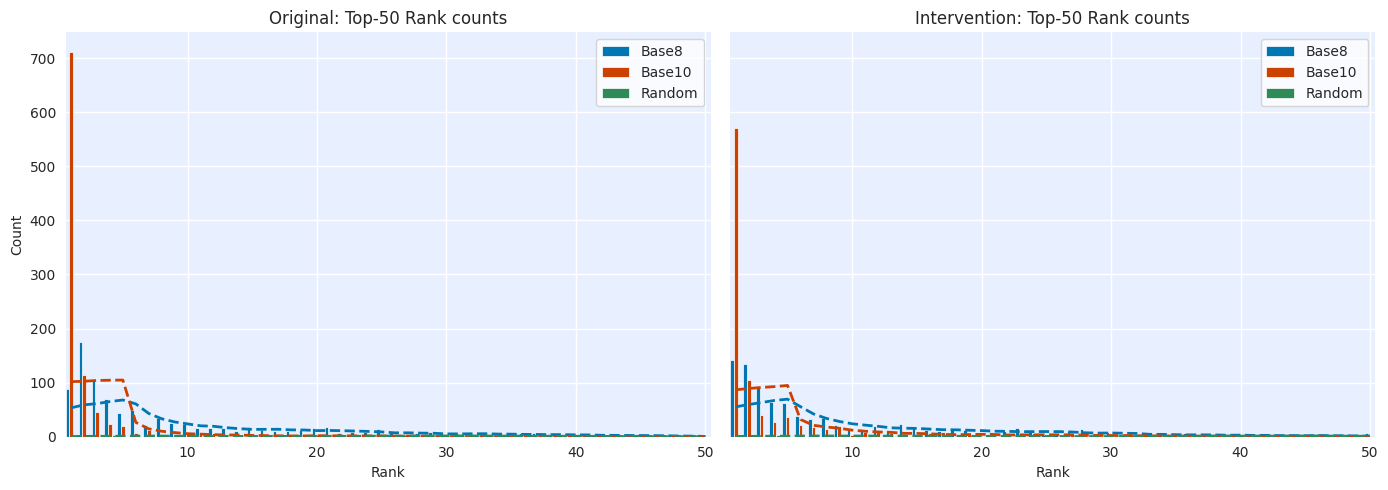

In [ ]:
# Top-50 grouped bar histograms in same axes (side-by-side counts)

# Params
top_k = 50
x = np.arange(1, top_k + 1)

if 'hist_counts_topk' not in globals():
    def hist_counts_topk(arr, k=top_k):
        a = arr.astype(int)
        a = a[(a >= 1) & (a <= k)]
        c = np.bincount(a - 1, minlength=k)
        return c

# Prepare counts
orig_base   = hist_counts_topk(corr_orig)
orig_base10 = hist_counts_topk(rw_orig)
orig_rand   = hist_counts_topk(rand_orig)
int_base    = hist_counts_topk(corr_int)
int_base10  = hist_counts_topk(rw_int)
int_rand    = hist_counts_topk(rand_int)

# Grouped bars settings
width = 0.28
colors = { 'base': "#0077B3", 'base10': "#CC4100", 'random': "#2E8B57" }

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.patch.set_facecolor('white')

# Original subplot
ax = axes[0]
ax.bar(x - width, orig_base,   width=width, color=colors['base'],   edgecolor='white', linewidth=0.5, label=f"Base{cfg.base}")
ax.bar(x,          orig_base10, width=width, color=colors['base10'], edgecolor='white', linewidth=0.5, label="Base10")
ax.bar(x + width,  orig_rand,   width=width, color=colors['random'], edgecolor='white', linewidth=0.5, label="Random")
# Overlay smoothed distribution lines
if 'smooth' not in globals():
    def smooth(y, frac=0.15, min_k=3, max_k=21):
        n = len(y)
        k = int(round(frac * n))
        k = max(min_k, min(max_k, k))
        if k % 2 == 0:
            k += 1
        k = min(k, n if n % 2 == 1 else max(1, n - 1))
        if k < 3:
            return y
        w = np.ones(k) / k
        return np.convolve(y, w, mode='same')
ax.plot(x, smooth(orig_base),   color=colors['base'],   linewidth=2.0, zorder=3, linestyle='--')
ax.plot(x, smooth(orig_base10), color=colors['base10'], linewidth=2.0, zorder=3, linestyle='--')
ax.plot(x, smooth(orig_rand),   color=colors['random'], linewidth=2.0, zorder=3, linestyle='--')
#ax.set_title("Original: Top-50 Rank counts")
ax.set_xlabel("Rank")
ax.set_ylabel("Count")
ax.set_xlim(1 - 1.5*width, top_k + 1.5*width)
ax.set_facecolor(light_blue)
ax.grid(True, color='white', linewidth=1.0)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()

# Intervention subplot
ax2 = axes[1]
ax2.bar(x - width, int_base,   width=width, color=colors['base'],   edgecolor='white', linewidth=0.5, label=f"Base{cfg.base}")
ax2.bar(x,          int_base10, width=width, color=colors['base10'], edgecolor='white', linewidth=0.5, label="Base10")
ax2.bar(x + width,  int_rand,   width=width, color=colors['random'], edgecolor='white', linewidth=0.5, label="Random")
# Overlay smoothed distribution lines
ax2.plot(x, smooth(int_base),   color=colors['base'],   linewidth=2.0, zorder=3, linestyle='--')
ax2.plot(x, smooth(int_base10), color=colors['base10'], linewidth=2.0, zorder=3, linestyle='--')
ax2.plot(x, smooth(int_rand),   color=colors['random'], linewidth=2.0, zorder=3, linestyle='--')
ax2.set_title("Intervention: Top-50 Rank counts")
ax2.set_xlabel("Rank")
ax2.set_xlim(1 - 1.5*width, top_k + 1.5*width)
ax2.set_facecolor(light_blue)
ax2.grid(True, color='white', linewidth=1.0)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.legend()

plt.tight_layout()
plt.show()


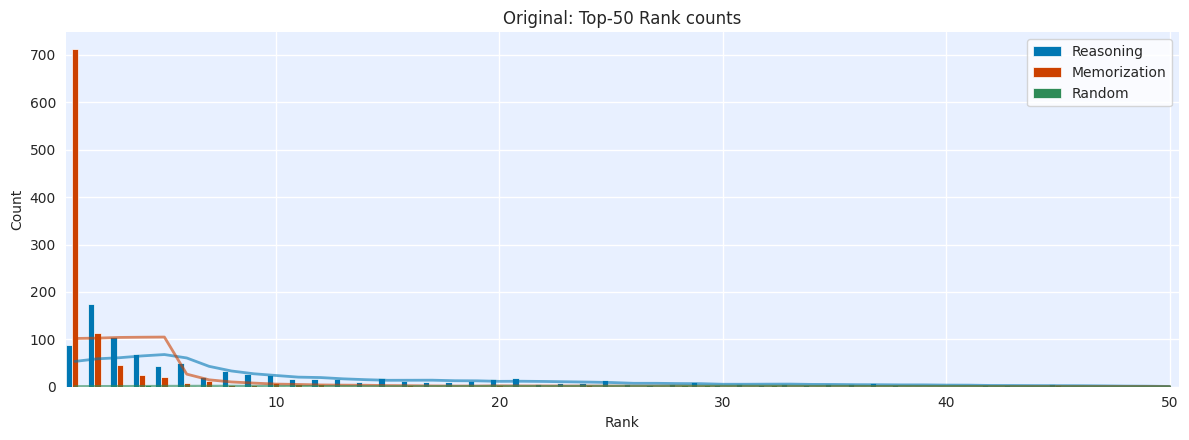

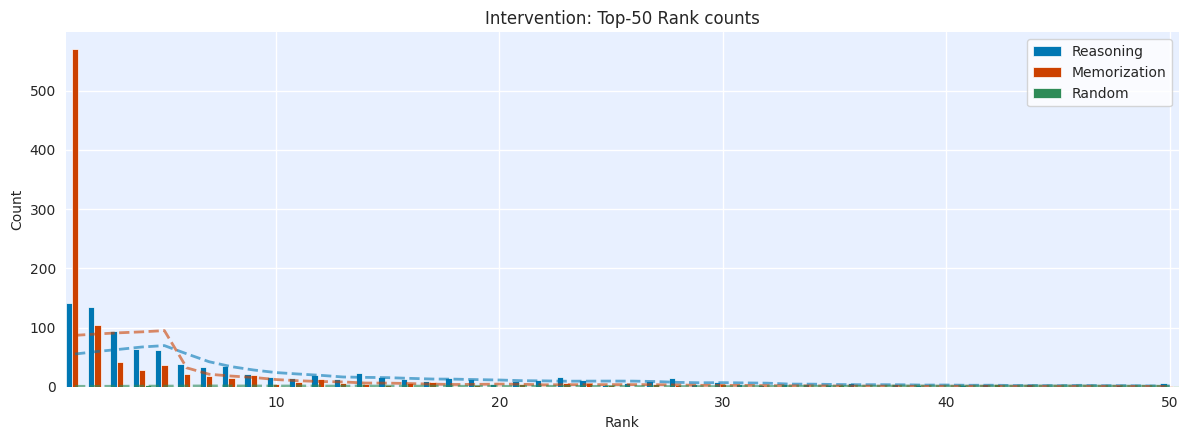

In [27]:
# Separate plots: Original and Intervention (Top-50), with renamed labels

# Ensure helpers and params
try:
    top_k
except NameError:
    top_k = 50
x = np.arange(1, top_k + 1)

if 'hist_counts_topk' not in globals():
    def hist_counts_topk(arr, k=top_k):
        a = arr.astype(int)
        a = a[(a >= 1) & (a <= k)]
        c = np.bincount(a - 1, minlength=k)
        return c

# Counts
orig_reason   = hist_counts_topk(corr_orig)
orig_mem      = hist_counts_topk(rw_orig)
orig_random   = hist_counts_topk(rand_orig)
int_reason    = hist_counts_topk(corr_int)
int_mem       = hist_counts_topk(rw_int)
int_random    = hist_counts_topk(rand_int)

# Plot settings
width = 0.28
colors = { 'reason': "#0077B3", 'mem': "#CC4100", 'random': "#2E8B57" }

# Original figure
fig1, ax1 = plt.subplots(figsize=(12, 4.5))
fig1.patch.set_facecolor('white')
ax1.bar(x - width, orig_reason, width=width, color=colors['reason'], edgecolor='white', linewidth=0.5, label="Reasoning")
ax1.bar(x,          orig_mem,    width=width, color=colors['mem'],    edgecolor='white', linewidth=0.5, label="Memorization")
ax1.bar(x + width,  orig_random, width=width, color=colors['random'], edgecolor='white', linewidth=0.5, label="Random")
# Optional smoothed overlays for readability
if 'smooth' not in globals():
    def smooth(y, frac=0.15, min_k=3, max_k=21):
        n = len(y)
        k = int(round(frac * n))
        k = max(min_k, min(max_k, k))
        if k % 2 == 0:
            k += 1
        k = min(k, n if n % 2 == 1 else max(1, n - 1))
        if k < 3:
            return y
        w = np.ones(k) / k
        return np.convolve(y, w, mode='same')
ax1.plot(x, smooth(orig_reason), color=colors['reason'], linewidth=2.0, alpha=0.6, zorder=3)
ax1.plot(x, smooth(orig_mem),    color=colors['mem'],    linewidth=2.0, alpha=0.6, zorder=3)
ax1.plot(x, smooth(orig_random), color=colors['random'], linewidth=2.0, alpha=0.6, zorder=3)
ax1.set_title("Original: Top-50 Rank counts")
ax1.set_xlabel("Rank")
ax1.set_ylabel("Count")
ax1.set_xlim(1 - 1.5*width, top_k + 1.5*width)
ax1.set_facecolor(light_blue)
ax1.grid(True, color='white', linewidth=1.0)
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.legend()
plt.tight_layout()
plt.show()

# Intervention figure
fig2, ax2 = plt.subplots(figsize=(12, 4.5))
fig2.patch.set_facecolor('white')
ax2.bar(x - width, int_reason, width=width, color=colors['reason'], edgecolor='white', linewidth=0.5, label="Reasoning")
ax2.bar(x,          int_mem,    width=width, color=colors['mem'],    edgecolor='white', linewidth=0.5, label="Memorization")
ax2.bar(x + width,  int_random, width=width, color=colors['random'], edgecolor='white', linewidth=0.5, label="Random")
ax2.plot(x, smooth(int_reason), color=colors['reason'], linewidth=2.0, alpha=0.6, linestyle='--', zorder=3)
ax2.plot(x, smooth(int_mem),    color=colors['mem'],    linewidth=2.0, alpha=0.6, linestyle='--', zorder=3)
ax2.plot(x, smooth(int_random), color=colors['random'], linewidth=2.0, alpha=0.6, linestyle='--', zorder=3)
ax2.set_title("Intervention: Top-50 Rank counts")
ax2.set_xlabel("Rank")
ax2.set_ylabel("Count")
ax2.set_xlim(1 - 1.5*width, top_k + 1.5*width)
ax2.set_facecolor(light_blue)
ax2.grid(True, color='white', linewidth=1.0)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.legend()
plt.tight_layout()
plt.show()
